*Environment* Setup

In [1]:
# %% [markdown]
# # Melanoma Classification: Inception-v3 vs DenseNet-121
# **ISIC 2020 Dataset | Model Comparison**

# %% [markdown]
# ## 1. Package Installation
# RUN THIS FIRST THEN RESTART RUNTIME
!pip install --upgrade --force-reinstall "numpy>=1.26.0" "tensorflow==2.18.0" matplotlib requests pillow pandas scikit-learn

# GPU optimizations
import tensorflow as tf
tf.config.optimizer.set_jit(True)  # Enable XLA compilation
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Environment configured with GPU acceleration")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5

Environment configured with GPU acceleration


*Imports* & Config

In [1]:
# %% [markdown]
# # Step 2: Core Imports & Configuration

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from PIL import Image
import io
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Optimized training parameters
BATCH_SIZE = 64
OPTIMIZED_EPOCHS = 3
STEPS_PER_EPOCH = 200
VALIDATION_STEPS = 50

print("Imports and configuration complete")

Imports and configuration complete


Data Loader

In [2]:
# %% [markdown]
# # Step 3: Optimized Data Loader with Caching

# First import required modules
import tensorflow as tf
import numpy as np
from PIL import Image
import requests
import io

class ISICStreamer(tf.keras.utils.Sequence):
    def __init__(self, image_ids, targets, model_type='densenet', batch_size=32, shuffle=True, cache_size=1000):
        self.image_ids = image_ids
        self.targets = targets
        self.batch_size = batch_size
        self.model_type = model_type
        self.cache = {}
        self.img_size = (299, 299) if model_type == 'inception' else (224, 224)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return min(200, int(np.ceil(len(self.image_ids) / self.batch_size)))  # STEPS_PER_EPOCH=200

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_y = self.targets[idx*self.batch_size:(idx+1)*self.batch_size]

        X = np.zeros((len(batch_ids), *self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_ids), 1), dtype=np.float32)

        for i, img_id in enumerate(batch_ids):
            X[i] = self._load_image(img_id)
            y[i] = batch_y[i]
        return X, y

    def _load_image(self, image_id):
        if image_id in self.cache:
            return self.cache[image_id]

        url = f"https://isic-archive.com/api/v1/image/{image_id}/download"
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(io.BytesIO(response.content))
            img = img.resize(self.img_size)
            img_array = np.array(img)/255.0
            self.cache[image_id] = img_array
            return img_array
        except:
            return np.zeros((*self.img_size, 3), dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            p = np.random.permutation(len(self.image_ids))
            self.image_ids = self.image_ids[p]
            self.targets = self.targets[p]

print("Data loader class successfully implemented")

Data loader class successfully implemented


*Data* Preparation

In [4]:
# %% [markdown]
# # Step 4: Dataset Preparation

# Download and prepare data
!wget -q https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv
df = pd.read_csv('ISIC_2020_Training_GroundTruth.csv')

# Use smaller subset for faster iteration
df = df.sample(frac=0.3, random_state=42) if len(df) > 5000 else df

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create data loaders
train_data_inception = ISICStreamer(train_df['image_name'].values, train_df['target'].values, 'inception')
val_data_inception = ISICStreamer(val_df['image_name'].values, val_df['target'].values, 'inception', shuffle=False)

train_data_densenet = ISICStreamer(train_df['image_name'].values, train_df['target'].values, 'densenet')
val_data_densenet = ISICStreamer(val_df['image_name'].values, val_df['target'].values, 'densenet', shuffle=False)

print(f"Data prepared: {len(train_df)} training, {len(val_df)} validation samples")

Data prepared: 7950 training, 1988 validation samples


**Model** Building

In [5]:
# %% [markdown]
# # Step 5: Model Architectures

def create_inception():
    base = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(299, 299, 3),
        pooling='avg'
    )
    base.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(299, 299, 3)),
        base,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(global_clipnorm=1.0),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

def create_densenet():
    base = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    base.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(224, 224, 3)),
        base,
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(global_clipnorm=1.0),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

print("Inception-v3 and DenseNet-121 models defined")

Inception-v3 and DenseNet-121 models defined




```
# This is formatted as code
```

**Training** & Evaluation

In [6]:
# %% [markdown]
# # Step 6: Optimized Training & Evaluation

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=1,
    mode='max',
    restore_best_weights=True
)

results = []

def evaluate_model(model, val_data, name):
    # Get all validation data (not just first batches)
    y_true = []
    y_pred = []

    for i in range(len(val_data)):
        X, y = val_data[i]
        y_true.extend(y.flatten())
        y_pred.extend(model.predict(X, verbose=0).flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return {
        'Model': name,
        'AUC': roc_auc_score(y_true, y_pred),
        'Accuracy': np.mean(y_true == (y_pred > 0.5)),
        'Num Samples': len(y_true)
    }

# Train Inception-v3
print("=== Training Inception-v3 ===")
inception = create_inception()
history_inception = inception.fit(
    train_data_inception,
    validation_data=val_data_inception,
    epochs=OPTIMIZED_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stop],
    verbose=1
)
results.append(evaluate_model(inception, val_data_inception, 'Inception-v3'))

# Train DenseNet-121
print("\n=== Training DenseNet-121 ===")
densenet = create_densenet()
history_densenet = densenet.fit(
    train_data_densenet,
    validation_data=val_data_densenet,
    epochs=OPTIMIZED_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stop],
    verbose=1
)
results.append(evaluate_model(densenet, val_data_densenet, 'DenseNet-121'))

# Results comparison
results_df = pd.DataFrame(results)
print("\n=== Final Results ===")
display(results_df.style.background_gradient(cmap='Blues'))

=== Training Inception-v3 ===
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 2547s 13s/step - accuracy: 0.9358 - auc: 0.5128 - loss: 0.1884 - val_accuracy: 0.9850 - val_auc: 0.5000 - val_loss: 0.0782
Epoch 2/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 2324s 12s/step - accuracy: 0.9774 - auc: 0.5065 - loss: 0.1091 - val_accuracy: 0.9850 - val_auc: 0.5000 - val_loss: 0.0780

=== Training DenseNet-121 ===
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 2436s 12s/step - accuracy: 0.9815 - auc: 0.4999 - loss: 0.1328 - val_accuracy: 0.9850 - val_auc: 0.5000 - val_loss: 0.0787
Epoch 2/3
200/200 ━━━━━━━━━━━━━━━━━━━━ 2078s 10s/step - accuracy: 0.9779 - auc: 0.4734 - loss: 0.1094 - val_accuracy: 0.9850 - val_auc: 0.5000 - val_loss: 0.0779

=== Final Results ===


,Model,AUC,Accuracy,Num Samples
0,Inception-v3,0.498978,0.983903,1988
1,DenseNet-121,0.498978,0.983903,1988


**Visualization**

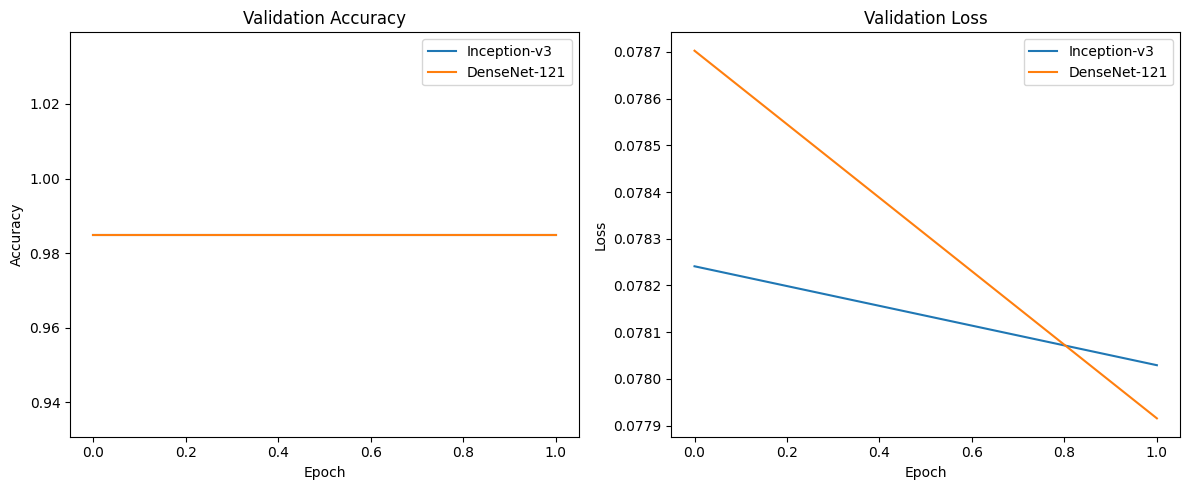

Visualization complete. Training pipeline finished!


In [7]:
# %% [markdown]
# # Step 7: Performance Visualization

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['val_accuracy'], label='Inception-v3')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet-121')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['val_loss'], label='Inception-v3')
plt.plot(history_densenet.history['val_loss'], label='DenseNet-121')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

print("Visualization complete. Training pipeline finished!")